这个文件是关于加州房价预测的一个ipynb代码，按照李沐大神的方法训练一下测试集，优化器使用Adam，模型采用MLP的思想

In [2]:
# 导入所需的库
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 定义下载数据的函数
import hashlib
import os
import tarfile
import zipfile
import requests

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

# 下载房价数据集

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


In [24]:
# 训练集数据预处理，需要将训练集进行一遍数据筛选，输入训练集，返回gt和features
# 去掉第一列以序号为内容的列
# 将NAN填充为0
def train_data_preprocess(train_data: pd.DataFrame) -> tuple[torch.tensor, torch.tensor]:
    price_gt = train_data.iloc[:, -1]
    features = train_data.iloc[:, 1:-1]
    # 发现alley这一列NA很多，表示数据并没有什么作用，可以删除
    features = features.drop(columns='Alley')
    # 将数值的列找出，将所有的数据都减去该列的平均值，找到空缺数据进行填充将其填充为0
    # NOTE(@shenqiren):
    # 这里解释一下，因为将所有数据都减去平均值后，该列的平均值就成了0，所以空缺数据直接填充为0就好
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    features[numeric_features] = features[numeric_features].fillna(0)

    # 下面再将所有非数值的列进行one-hot编码
    features = pd.get_dummies(features, dummy_na=True)
    if features.isnull().values.any():
        raise ValueError("DataFrame contains NaN values which cannot be converted to a tensor.")
    # dtypes = features.dtypes
    # non_float64_or_bool_columns = dtypes[~dtypes.isin(['float64', 'bool'])]
    price_gt = torch.tensor(price_gt.to_numpy().astype(np.float32), dtype=torch.float32)
    features = torch.tensor(features.to_numpy().astype(np.float32), dtype=torch.float32)

    return price_gt, features

def test_data_preprocess(test_data: pd.DataFrame) -> torch.tensor:
    features = test_data.iloc[:, 1:]
    return features

price_gt, features = train_data_preprocess(train_data)
# test_features = test_data_preprocess(test_data)

In [38]:
# 定义训练模型的相关内容
# 定义损失函数
import functools
loss = nn.MSELoss()
in_features = features.shape[1]

# 定义训练网络，这里使用MLP来做，可以选择传入数据features的个数来生成，这里使用3层MLP来实现，每层的权重都随机初始化
# 因为这次的输出是一个价格，所以一定是正数，是否进行ReLU也无所谓
def get_mlp_net(input_num = in_features):
    net = nn.Sequential(nn.Flatten(), nn.Linear(input_num, input_num // 2), nn.Linear(input_num // 2, input_num // 2 // 2), nn.Linear(input_num // 2 // 2, 1))
    # NOTE(@shenqiren)
    # 为了防止梯度爆炸，所以这里使用Xavier初始化来保证数值稳定
    # 对每个子模块进行 Xavier 初始化
    for layer in net.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)  # 初始化偏置为0
    return net

# 比赛建议的损失函数是对数误差均方根函数
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()


In [42]:
# 定义训练过程
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [43]:
# 定义K折交叉验证
# 首先是获取K折的训练集和验证集数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 其次是定义K折交叉验证
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        # net = get_net()
        net = get_mlp_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1168])) that is different to the input size (torch.Size([1168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have t

折1，训练log rmse0.968434, 验证log rmse1.528330
折2，训练log rmse0.435523, 验证log rmse0.466996
折3，训练log rmse0.462478, 验证log rmse0.464894
折4，训练log rmse0.408823, 验证log rmse0.392968
折5，训练log rmse1.060522, 验证log rmse1.530427
5-折验证: 平均训练log rmse: 0.667156, 平均验证log rmse: 0.876723


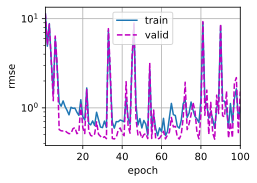

In [44]:
# 实现训练
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, features, price_gt, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')